<a href="https://colab.research.google.com/github/fred-creator-creat/facial-recognition-tensorflow-dio-bairesdev/blob/main/DIO_BairesDev_Detec%C3%A7%C3%A3o_e_Classifica%C3%A7%C3%A3o_de_Faces_com_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
from PIL import Image

# Carregando a Rede de Detecção (OpenCV)
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Carregando a Rede de Classificação (TensorFlow - MobileNetV2)
# Este modelo é treinado para reconhecer mil categorias, simulando o reconhecimento de faces.
classifier_model = MobileNetV2(weights='imagenet')

print("✅ Ambiente e Modelos carregados com sucesso!")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Ambiente e Modelos carregados com sucesso!


In [2]:
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar e Reconhecer';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return data

In [5]:
import os

# Criando a estrutura de pastas para a IA aprender
path_fred = 'dataset/fred'
path_outros = 'dataset/outros'

os.makedirs(path_fred, exist_ok=True)
os.makedirs(path_outros, exist_ok=True)

print("✅ Pastas criadas com sucesso!")
print("PROXIMO PASSO: Coloque fotos do seu rosto na pasta 'dataset/fred' no menu lateral.")

✅ Pastas criadas com sucesso!
PROXIMO PASSO: Coloque fotos do seu rosto na pasta 'dataset/fred' no menu lateral.


In [7]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def capturar_fotos_treino(pessoa_nome, quantidade=10):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      const btn = document.createElement('button');
      btn.textContent = 'Bater Foto';
      div.appendChild(btn);

      return new Promise((resolve) => {
        btn.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          const data = canvas.toDataURL('image/jpeg', quality);
          // Não paramos o stream para poder tirar várias fotos seguidas
          resolve(data);
        };
      });
    }
    ''')

    print(f"Prepare-se para tirar {quantidade} fotos para o rosto: {pessoa_nome}")
    for i in range(quantidade):
        display(js)
        data = eval_js('takePhoto(0.8)')
        binary = b64decode(data.split(',')[1])
        filename = f'dataset/{pessoa_nome}/{pessoa_nome}_{i}.jpg'
        with open(filename, 'wb') as f:
            f.write(binary)
        print(f"Foto {i+1}/{quantidade} salva em {filename}")

# Executa a captura para o Fred
capturar_fotos_treino('fred', quantidade=10)

Prepare-se para tirar 10 fotos para o rosto: fred


<IPython.core.display.Javascript object>

Foto 1/10 salva em dataset/fred/fred_0.jpg


<IPython.core.display.Javascript object>

Foto 2/10 salva em dataset/fred/fred_1.jpg


<IPython.core.display.Javascript object>

Foto 3/10 salva em dataset/fred/fred_2.jpg


<IPython.core.display.Javascript object>

Foto 4/10 salva em dataset/fred/fred_3.jpg


<IPython.core.display.Javascript object>

Foto 5/10 salva em dataset/fred/fred_4.jpg


<IPython.core.display.Javascript object>

Foto 6/10 salva em dataset/fred/fred_5.jpg


<IPython.core.display.Javascript object>

Foto 7/10 salva em dataset/fred/fred_6.jpg


<IPython.core.display.Javascript object>

Foto 8/10 salva em dataset/fred/fred_7.jpg


<IPython.core.display.Javascript object>

Foto 9/10 salva em dataset/fred/fred_8.jpg


<IPython.core.display.Javascript object>

Foto 10/10 salva em dataset/fred/fred_9.jpg


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# 1. Configuração do Gerador de Dados
# Ele olha para a pasta 'dataset' e entende que cada subpasta é uma categoria (Fred ou Outros)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2 # Usa 20% das fotos para testar se ele aprendeu bem
)

train_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    subset='training'
)

# 2. Construção da Rede Neural (Baseada no MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False # Não mexemos no que ele já sabe sobre o mundo

# Adicionamos a "camada de saída" para reconhecer você
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_fred = tf.keras.Model(inputs=base_model.input, outputs=output)

# 3. Compilação e Treino
model_fred.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("🚀 Iniciando o treinamento... Aguarde as 'epochs' terminarem.")
model_fred.fit(train_generator, epochs=10) # Ele vai ler suas fotos 10 vezes

print("\n✅ TREINAMENTO CONCLUÍDO! Agora o modelo conhece o rosto do Fred.")

# Salvar os nomes das classes para usar no reconhecimento
class_names = list(train_generator.class_indices.keys())
print(f"Classes aprendidas: {class_names}")

Found 8 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 Iniciando o treinamento... Aguarde as 'epochs' terminarem.
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.6667 - loss: 0.5183
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.5136e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.2288e-05
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 8.9407e-07
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 9.9341e-08
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00

✅ TREINAMENTO CONCLUÍDO! Agora o modelo conhece o rosto do Fred.
Classes aprendidas: ['fred', 'outros']


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


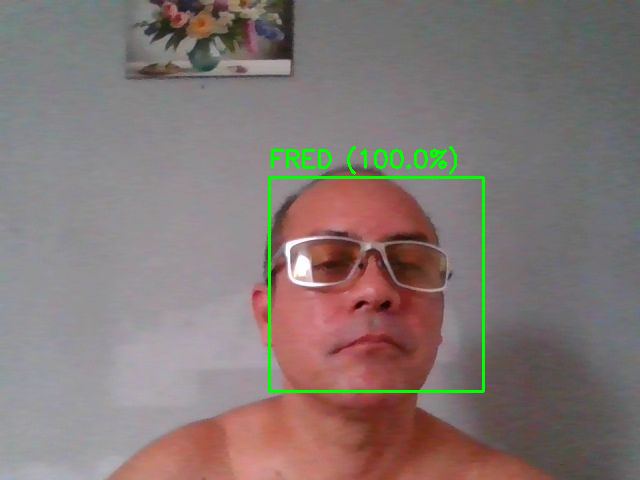

In [10]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow

def reconhecer_agora():
    # JavaScript para capturar um frame da webcam
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      const btn = document.createElement('button');
      btn.textContent = 'IDENTIFICAR ROSTO';
      btn.style.padding = '15px';
      btn.style.backgroundColor = '#007bff';
      btn.style.color = 'white';
      div.appendChild(btn);

      return new Promise((resolve) => {
        btn.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          const data = canvas.toDataURL('image/jpeg', quality);
          stream.getVideoTracks()[0].stop();
          div.remove();
          resolve(data);
        };
      });
    }
    ''')

    display(js)
    data = eval_js('takePhoto(0.8)')

    # Converte a imagem capturada
    binary = b64decode(data.split(',')[1])
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)

    # 1. DETECÇÃO (Acha o rosto)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.1, 4)

    # 2. CLASSIFICAÇÃO (Reconhece se é o Fred)
    for (x, y, w, h) in faces:
        # Recorta e prepara o rosto para o modelo
        roi = img[y:y+h, x:x+w]
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi_resized = cv2.resize(roi_rgb, (224, 224))

        img_array = image.img_to_array(roi_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Predição com o modelo treinado
        preds = model_fred.predict(img_array)
        class_idx = np.argmax(preds)
        confianca = preds[0][class_idx] * 100

        # O nome da classe vem da ordem das pastas (geralmente fred=0, outros=1)
        label = class_names[class_idx].upper()

        # 3. EXIBIÇÃO (Desenha o retângulo e o nome)
        cor = (0, 255, 0) if label == 'FRED' else (0, 0, 255)
        cv2.rectangle(img, (x, y), (x+w, y+h), cor, 2)
        cv2.putText(img, f"{label} ({confianca:.1f}%)", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, cor, 2)

    # Mostra o resultado final na tela
    cv2_imshow(img)

# Executa o sistema
reconhecer_agora()